In [995]:
from custom_dataset.segdataset import InstanceSegmentationDataset
from torch.utils.data import DataLoader
import json

import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
import evaluate
import logging
from utils import rs_utils
from datetime import datetime
from transformers import SegformerImageProcessor

In [996]:
#--- root 
root_dir = '/disk3/eric/dataset/Weapon_System/segmentation_pipes'

#--- time
current_time = datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

In [997]:
# for fewshot
id2label = {
    0:"background",
    1:"object"
}
label2id = {v: k for k, v in id2label.items()}

In [998]:
model_path = "/disk3/eric/checkpoints/military_fewshot_seg/202_mit-b5_fewshotformer_best_epoch_16_miou_0.9656.pt"

#-----------
_VERSION = "202"
_EPOCHS = 50
_N_SHOTS = 2 # 2(==1) or 5 or 10 
_N_INSTANCE = 1
_MODEL_SAVE = True
_MODEL_VERSION = "nvidia/mit-b5"
_MODEL_VERSION_SAVE = _MODEL_VERSION.split("/")[-1]
_BATCH_SIZE = 2
_DEVICE = "cuda:1"
#---------
Config_options = {
    "_VERSION": _VERSION,
    "_EPOCHS": _EPOCHS,
    "_N_SHOTS": _N_SHOTS,
    "_N_INSTANCE": _N_INSTANCE,
    "_MODEL_SAVE": _MODEL_SAVE,
    "_MODEL_VERSION": _MODEL_VERSION,
    "_MODEL_VERSION_SAVE": _MODEL_VERSION_SAVE,
    "_BATCH_SIZE": _BATCH_SIZE,
    "_DEVICE": _DEVICE,
}

In [999]:
#----------------------
from custom_dataset.segdataset import FewShotSegDataset_v2


image_processor = SegformerImageProcessor(reduce_labels=False,size={"height": 448, "width": 448})

train_dataset = FewShotSegDataset_v2(root_dir=root_dir, image_processor=image_processor,n_shots=_N_SHOTS,n_instance=_N_INSTANCE)
valid_dataset = FewShotSegDataset_v2(root_dir=root_dir, image_processor=image_processor,n_shots=_N_SHOTS,n_instance=_N_INSTANCE, train=False)

#train_dataset = InstanceSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
#valid_dataset = InstanceSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

train_dataloader = DataLoader(train_dataset, batch_size=_BATCH_SIZE, collate_fn=train_dataset.my_collate_fn, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=_BATCH_SIZE, collate_fn=train_dataset.my_collate_fn)

train pairs :  [['Zamak__part_21.png', 'Zamak__part_23.png'], ['M2A1Slammer2__part_24.png', 'M2A1Slammer2__part_23.png'], ['M5Sandstorm__part_26.png', 'M5Sandstorm__part_18.png'], ['M2A1Slammer2__part_23.png', 'M2A1Slammer2__part_24.png'], ['Zamak__part_23.png', 'Zamak__part_21.png'], ['M5Sandstorm__part_18.png', 'M5Sandstorm__part_26.png'], ['T140Angara__part_15.png', 'T140Angara__part_19.png'], ['T140Angara__part_19.png', 'T140Angara__part_15.png']]
valid pairs ;  [['M2A1Slammer2__part_23.png', 'Zamak__part_18.png'], ['M2A1Slammer2__part_23.png', 'M5Sandstorm__part_17.png'], ['M2A1Slammer2__part_23.png', 'T140Angara__part_8.png'], ['M2A1Slammer2__part_23.png', 'M2A1Slammer2__part_11.png'], ['M2A1Slammer2__part_23.png', 'city_part_4.png'], ['M2A1Slammer2__part_23.png', 'Zamak__part_9.png'], ['M2A1Slammer2__part_23.png', 'Zamak__part_12.png'], ['M2A1Slammer2__part_23.png', 'M2A1Slammer2__part_9.png'], ['M2A1Slammer2__part_23.png', 'M2A1Slammer2__part_17.png'], ['M2A1Slammer2__part_23.p

In [1000]:
# define model
from models.custom_segformer import FewShotFormer

seg_model = FewShotFormer.from_pretrained(_MODEL_VERSION,
                                        num_labels=2,
                                        id2label=id2label,
                                        label2id=label2id,
                                        force_download=False                                       
                                        )

# model freeze

# model freeze 
for param in seg_model.parameters():
    param.requires_grad = False

# decoder unfreeze 
for param in seg_model.decode_head.parameters():
    param.requires_grad = True

Some weights of FewShotFormer were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.custom_classifier.bias', 'decode_head.custom_classifier.weight', 'decode_head.custom_linear_fuse.weight', 'decode_head.custom_mlp.proj.bias', 'decode_head.custom_mlp.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.linear_fuse_support.weight']
You should probably TRAIN this model on a down-stream task to 

In [1001]:
BACKBONE_SIZE = "large" # in ("small", "base", "large" or "giant")

backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

dinov2_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
#backbone_model.to(_DEVICE)

# model freeze 
for param in dinov2_model.parameters():
    param.requires_grad = False

Using cache found in /home/eric/.cache/torch/hub/facebookresearch_dinov2_main


In [1002]:
#-- model to device


seg_model.load_state_dict(torch.load(model_path))

seg_model = seg_model.to(_DEVICE)
dinov2_model = dinov2_model.to(_DEVICE) 


In [1003]:
import random
select = random.randint(0, len(valid_dataloader))

# Create an iterator for the valid_dataloader outside the loop
#iterator = iter(valid_dataloader)

# for i in range(select):
#     try:
#         batch = next(iterator)  # Get the next batch from the iterator
#     except StopIteration:
#         # Handle the case where the iterator has exhausted the data
#         print("End of data reached!")
#         break

batch = valid_dataset.__getitem__(select)
support_pixel_values, support_labels = batch["support"]['images'].unsqueeze(0).to(_DEVICE), batch["support"]["labels"].unsqueeze(0).to(_DEVICE) 
query_pixel_values, query_labels = batch["query"]['images'].unsqueeze(0).to(_DEVICE), batch["query"]["labels"].unsqueeze(0).to(_DEVICE) 
labels = query_labels

filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/train/images/M2A1Slammer2__part_24.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/train/labels/M2A1Slammer2__part_24.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/train/images/city_part_3.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/train/labels/city_part_3.png


In [1004]:
#-----
patch_token = dinov2_model.forward_features(query_pixel_values)
patch_token = patch_token["x_norm_patchtokens"]
patch_token = patch_token.reshape([query_pixel_values.shape[0],-1,32,32])

In [1005]:
outputs = seg_model(pixel_values=support_pixel_values, labels=labels,dino_features = patch_token)
loss, logits = outputs.loss, outputs.logits

support_states  torch.Size([1, 768, 112, 112])
query_states  torch.Size([1, 1024, 32, 32])
query_states  torch.Size([1, 768, 112, 112])
mask type :  <class 'torch.Tensor'>
mask shape :  torch.Size([1, 448, 448])
weighted_support_states torch.Size([1, 768, 112, 112])
all_factors :  torch.Size([1, 2304, 112, 112])


In [1006]:
with torch.no_grad():
    upsampled_logits = nn.functional.interpolate(
        logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
    )
    predicted = upsampled_logits.argmax(dim=1)

In [1007]:
import matplotlib.pyplot as plt
support_pixel_values, support_labels = support_pixel_values.to("cpu"), support_labels.to("cpu")
query_pixel_values, query_labels = query_pixel_values.to("cpu"), query_labels.to("cpu")

In [1008]:
import utils.rs_utils

In [1009]:
query_pixel_values.shape

torch.Size([1, 3, 448, 448])

Error in callback <function _draw_all_if_interactive at 0x7f5907d870d0> (for post_execute):


KeyboardInterrupt: 

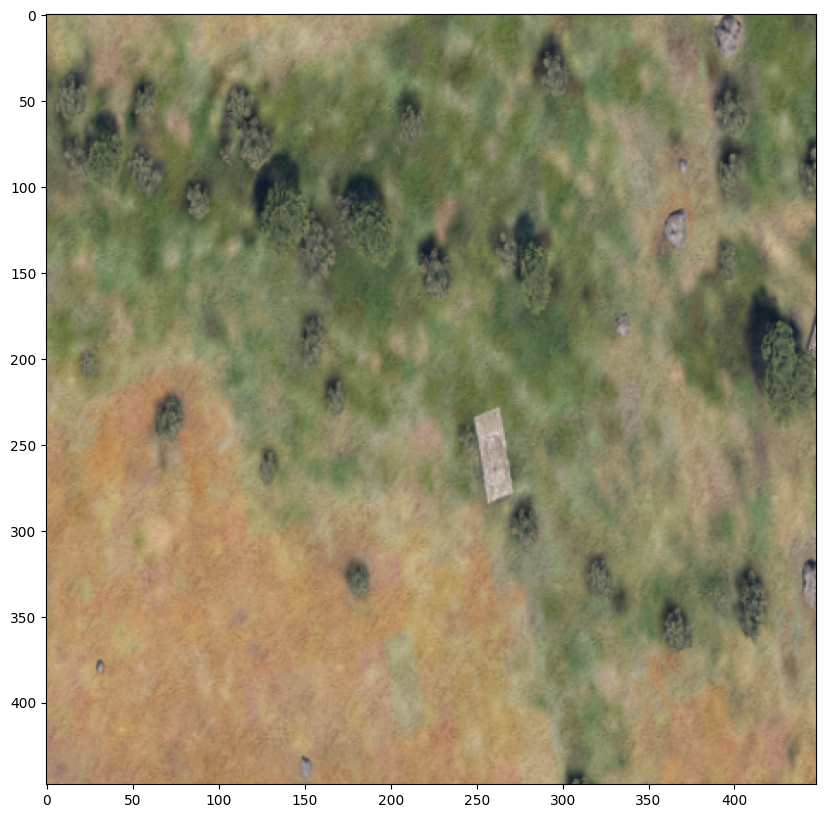

In [1010]:
rs_utils.torch_display(support_pixel_values,True,True)

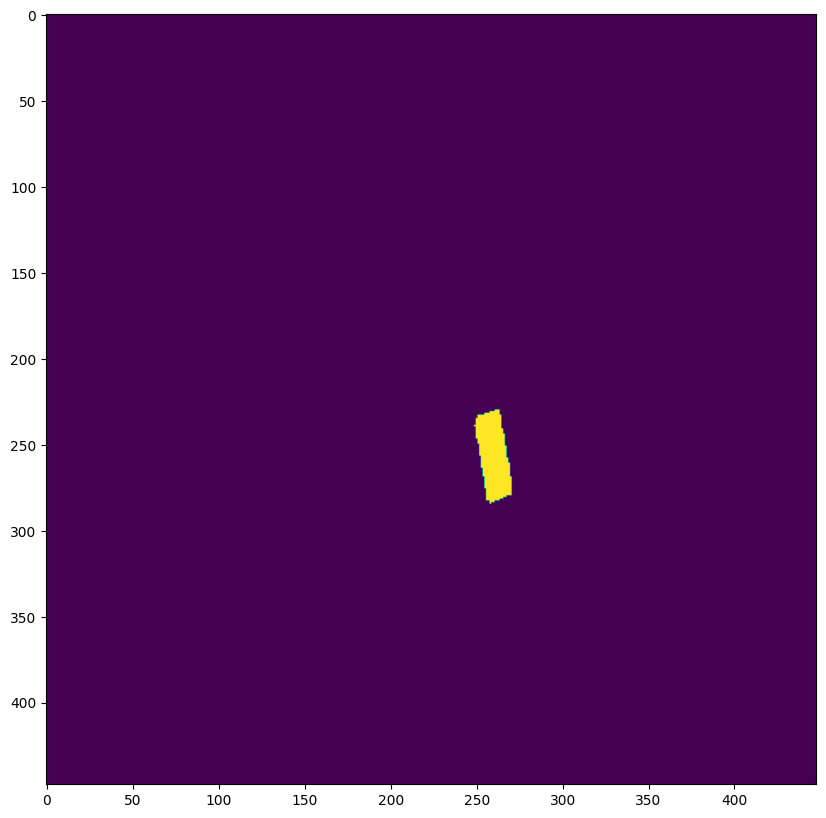

In [ ]:
fig_size= (10,10)
plt.figure(figsize=fig_size)
plt.imshow(support_labels[0,:])

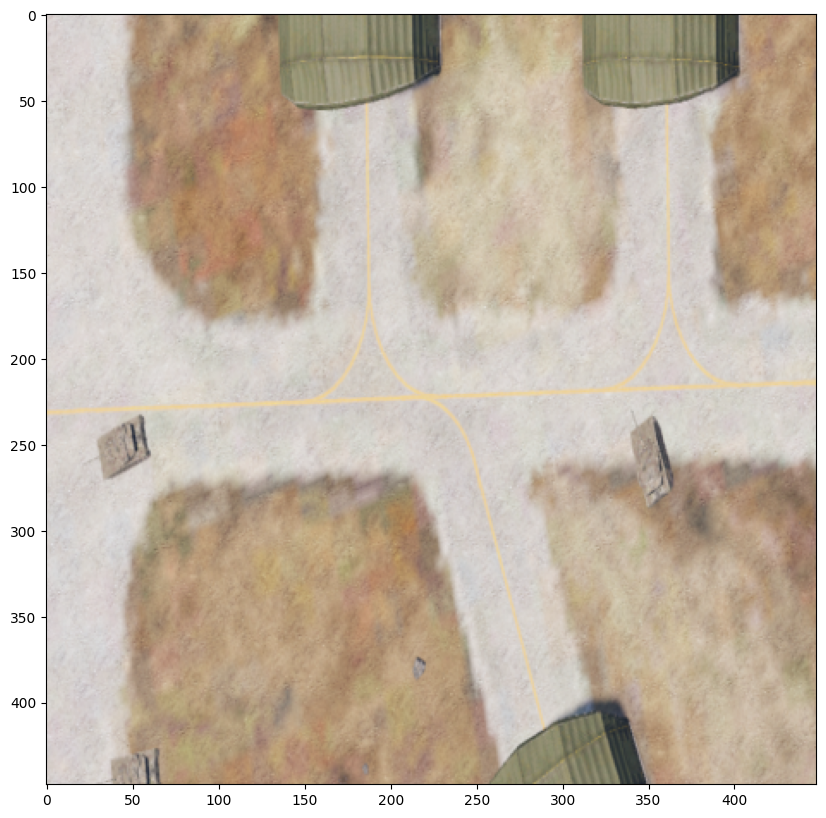

In [ ]:
rs_utils.torch_display(query_pixel_values,True,True)

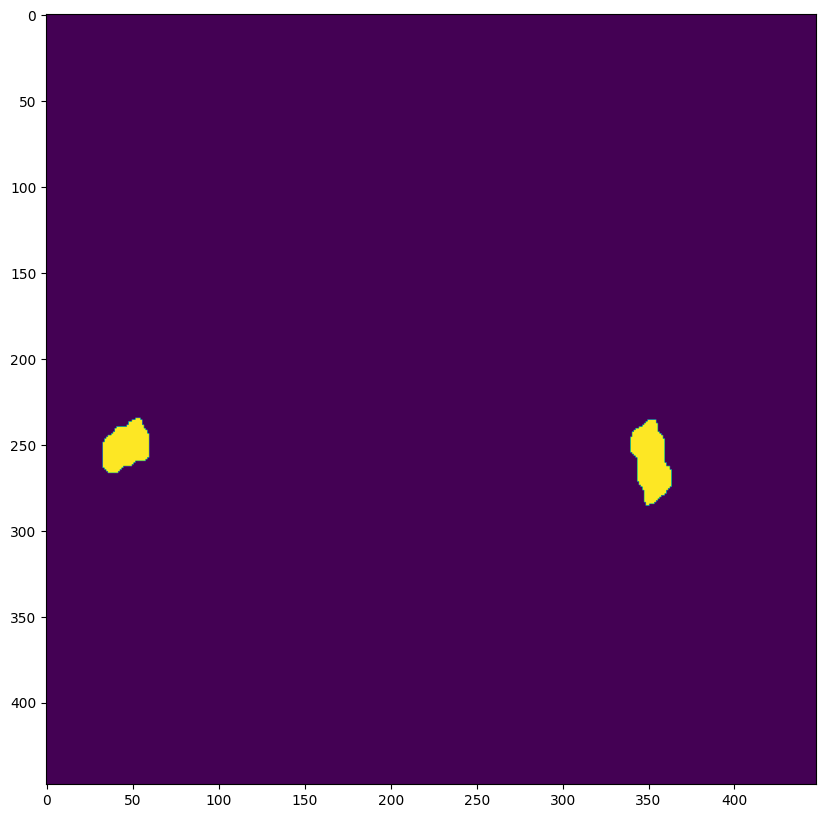

In [ ]:
predicted = predicted.to("cpu")
fig_size= (10,10)
plt.figure(figsize=fig_size)
plt.imshow(predicted[0,:])

In [ ]:
batch[0].keys()

KeyError: 0

In [ ]:
batch[0]['pixel_values'].shape

torch.Size([2, 3, 448, 448])

In [ ]:
batch[1].keys()

dict_keys(['pixel_values', 'labels'])

In [ ]:
support_pixel_values, support_labels = batch[0]["pixel_values"].to(_DEVICE), batch[0]["labels"].to(_DEVICE) 
query_pixel_values, query_labels = batch[1]["pixel_values"].to(_DEVICE), batch[1]["labels"].to(_DEVICE) 
labels = query_labels

In [ ]:
support_pixel_values.shape

torch.Size([2, 3, 448, 448])

In [ ]:
patch_token = dinov2_model.forward_features(query_pixel_values)
patch_token = patch_token["x_norm_patchtokens"]
patch_token = patch_token.reshape([query_pixel_values.shape[0],-1,32,32])

In [ ]:
seg_model.load_state_dict(torch.load("/disk3/eric/checkpoints/military_fewshot_seg/070_mit-b5_fewshotformer_best_epoch_40_miou_0.9765.pt"))

<All keys matched successfully>

In [ ]:
outputs = seg_model(pixel_values=support_pixel_values, labels=labels, dino_features = patch_token)

support_states  torch.Size([2, 768, 112, 112])
query_states  torch.Size([2, 1024, 32, 32])
query_states  torch.Size([2, 768, 112, 112])
mask type :  <class 'torch.Tensor'>
mask shape :  torch.Size([2, 448, 448])
weighted_support_states torch.Size([2, 768, 112, 112])
all_factors :  torch.Size([2, 2304, 112, 112])


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/valid/images/M2A1Slammer2__part_13.png


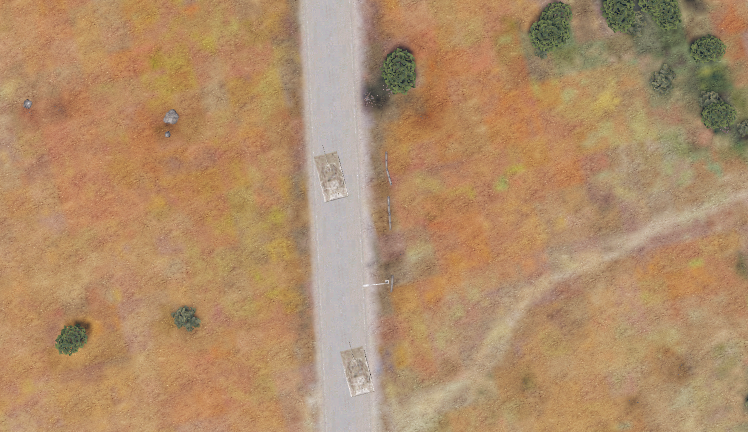

In [ ]:
import random
from PIL import Image
img_root = "/disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/valid/images"
rand_id = random.randint(0,len(os.listdir("/disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/valid/images")))
img_name = os.listdir(img_root)[rand_id]
image = Image.open(os.path.join(img_root, img_name))
image

In [ ]:
image.size

(748, 432)

In [ ]:
from torchvision import transforms
transform = transforms.Compose([
    # Resize the image to the specified size
    transforms.Resize((512, 512)),  # (height, width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
transformed_image = transform(image)

In [ ]:
transformed_image.shape

torch.Size([3, 512, 512])

In [ ]:
transformed_image_ = transformed_image.unsqueeze(0)

In [ ]:
transformed_image_.shape

torch.Size([1, 3, 512, 512])

In [ ]:
model.eval()
outputs = model(transformed_image_)

In [ ]:
shape_ = transformed_image.shape[-2:]

upsampled_logits = nn.functional.interpolate(
    outputs['logits'], size=shape_, mode="bilinear", align_corners=False)
predicted = upsampled_logits.argmax(dim=1)

In [ ]:
predicted.shape

torch.Size([1, 512, 512])

In [ ]:
import numpy as np
predicted_np = np.asarray( predicted.permute(1,2,0) )

In [ ]:
id2label

{0: 'background',
 1: 'M2A1Slammer',
 2: 'M5SandstormMLRS',
 3: 'T140Angara',
 4: 'ZamakMRL'}

In [ ]:
colormap = {
    0: (0, 0, 0),        # Black for background
    1: (255, 0, 0),      # Red for M2A1Slammer
    2: (0, 255, 0),      # Green for M5SandstormMLRS
    3: (0, 0, 255),      # Blue for T140Angara
    4: (255, 255, 0)     # Yellow for ZamakMRL
}

In [ ]:
np.unique( predicted_np )

array([0, 1, 3])

In [ ]:
rgb_image = np.repeat(predicted_np, 3, axis=-1)


In [ ]:
for key,value in colormap.items():
    mask = (rgb_image == [key, key, key]).all(axis=-1)
    rgb_image[mask] = value   

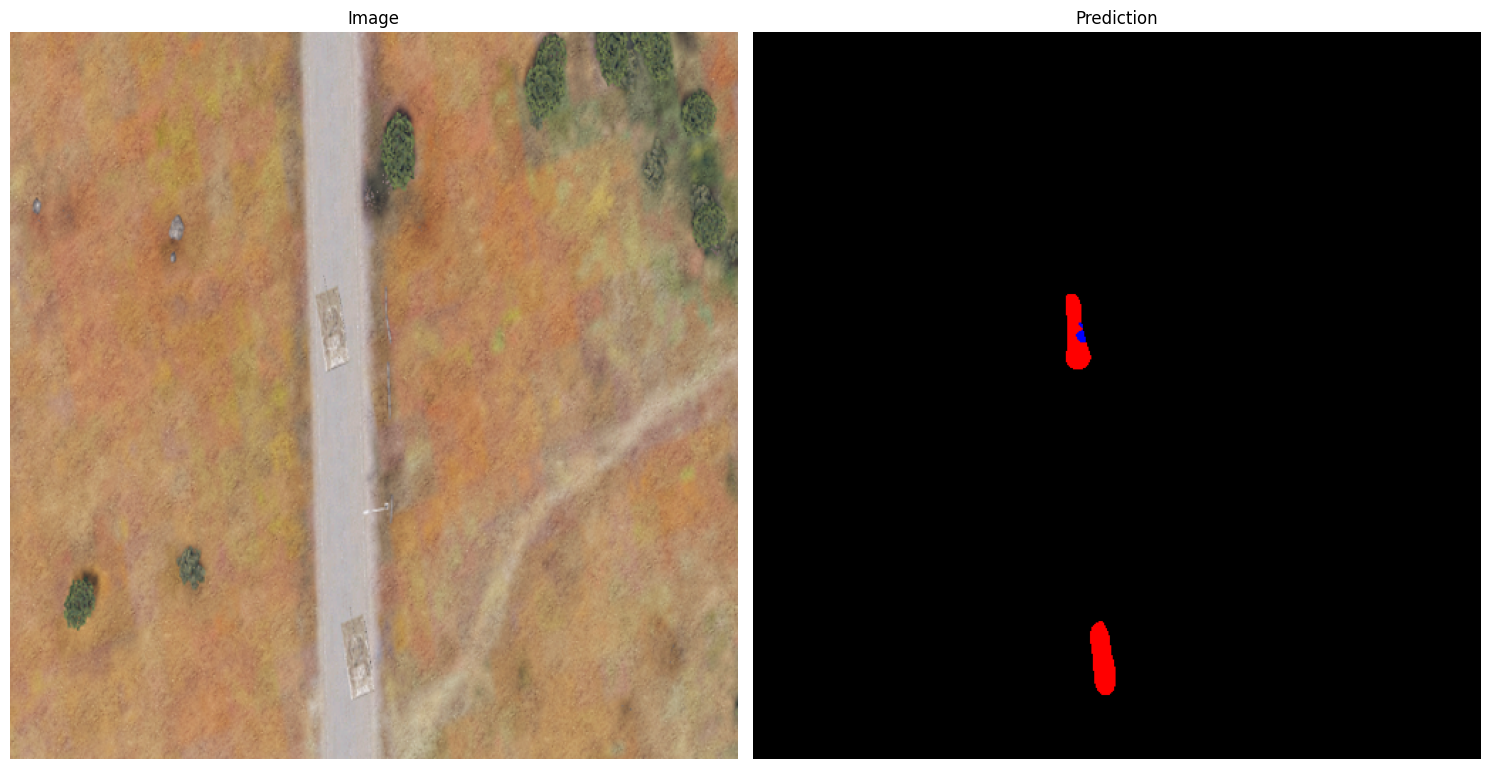

: 

In [ ]:
import matplotlib.pyplot as plt
# Create a figure with two subplots in a single row
fig, axes = plt.subplots(1, 2, figsize=(15, 10))  # 1 row, 2 columns

#----- image was resized
new_size = (512, 512)  # (width, height)

# Resize the image
resized_image = image.resize(new_size)  

# Display the first image in the first subplot
axes[0].imshow(resized_image)
axes[0].set_title("Image")  # Optional: Add a title
axes[0].axis("off")           # Turn off the axes for better visualization

# Display the second image in the second subplot
axes[1].imshow(rgb_image)
axes[1].set_title("Prediction")  # Optional: Add a title
axes[1].axis("off")           # Turn off the axes

# Show the combined figure
plt.tight_layout()
plt.show()